In [76]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import time

import dpf
import dpf_toy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
iterations = 100

# (x, y, theta)
states = [np.array([0.0, 0.0, 0.0])]
controls = []
observations = []

beacon_observer = dpf_toy.BeaconObserver()
beacon_observer.add_beacon((5, 3), 0.2)
beacon_observer.add_beacon((22, 8), 0.5)

dynamics = dpf_toy.RobotDynamicsModel()

# Simulation
for _ in range(iterations):
    control = torch.from_numpy(np.random.uniform(
        low=[0, -0.1], high=[1, 0.1], size=(2,)).astype(np.float32))
    new_state = dynamics.forward(
        torch.from_numpy(states[-1][np.newaxis, :].astype(np.float32)), control, noisy=True)

    states.append(new_state[0].numpy())
    controls.append(control.numpy())
true_states = np.array(states)

# Dead-reckoning
states = [true_states[0]]
for control in controls:
    new_state = dynamics.forward(
        torch.from_numpy(states[-1][np.newaxis, :].astype(np.float32)), control, noisy=False)
    states.append(new_state[0].numpy())
dead_reckoned_states = np.array(states)


In [84]:

# Particle filter network
dynamics = dpf_toy.RobotDynamicsModel()
measurements = dpf_toy.DeepBeaconMeasurementModel()

pfnet = dpf.ParticleFilterNetwork(dynamics, measurements, 0.5)
pfnet.train()


ParticleFilterNetwork(
  (dynamics_model): RobotDynamicsModel()
  (measurement_model): DeepBeaconMeasurementModel(
    (observation_layers): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (state_layers): Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (shared_layers): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=1, bias=True)
      (7): LogSigmoid()
    )
  )
)

In [85]:
model = pfnet

total_epochs = 0
optimizer = optim.Adam(model.parameters())

def set_lr(lr):
    print("Setting learning rate to", lr)
    for g in optimizer.param_groups:
        g['lr'] = lr

def train(epoch, log_interval=10):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        start = time.time()

        observations = beacon_observer.forward(true_states[1:])
        states = [true_states[0]]
        num_particles = 1000
        particle_states = torch.FloatTensor(
            [true_states[0] for _ in range(num_particles)])
        particle_weights = torch.ones(num_particles)

        for i, (control, observation) in enumerate(zip(controls, observations)):
            # Type conversions
            observation = torch.from_numpy(observation.astype(np.float32))
            control = torch.from_numpy(control.astype(np.float32))

            # Particle filter network: forward
            best_state, particle_states, particle_weights = pfnet.forward(
                particle_states, particle_weights, observation, control)

            loss = F.mse_loss(particle_states[:,:2],
                             torch.from_numpy(true_states[i + 1][np.newaxis,:2].astype(np.float32)))
            
            print(loss.numpy())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        end = time.time()

        global total_epochs
        total_epochs += 1
        print('{}: {:.2f}s'.format(total_epochs, end-start))

In [86]:
train(5)

0.0066413367


/usr/lib/python3/dist-packages/ipykernel_launcher.py:34: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [87]:
observations = beacon_observer.forward(true_states[1:])
states = [true_states[0]]
num_particles = 1000
particle_states = torch.FloatTensor(
    [true_states[0] for _ in range(num_particles)])
particle_weights = torch.ones(num_particles)

for control, observation in zip(controls, observations):
    # Type conversions
    observation = torch.from_numpy(observation.astype(np.float32))
    control = torch.from_numpy(control.astype(np.float32))

    # Particle filter network: forward
    best_state, particle_states, particle_weights = pfnet.forward(
        particle_states, particle_weights, observation, control)

    states.append(best_state.numpy())
pf_states = np.array(states)


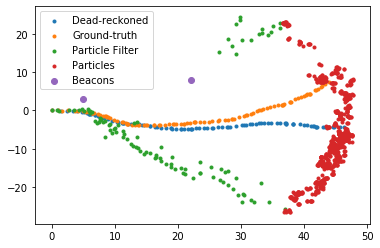

In [88]:

# Plot trajectories
plt.scatter(dead_reckoned_states[:, 0],
            dead_reckoned_states[:, 1], marker=".", label="Dead-reckoned")
plt.scatter(true_states[:, 0], true_states[:, 1],
            marker=".", label="Ground-truth")
plt.scatter(pf_states[:, 0], pf_states[:, 1],
            marker=".", label="Particle Filter")

pf_states = particle_states.numpy()
plt.scatter(pf_states[:, 0], pf_states[:, 1], marker=".", label="Particles")

# Plot beacons
beacon_locations = np.asarray(beacon_observer.locations)
plt.scatter(beacon_locations[:, 0], beacon_locations[:, 1], label="Beacons")

plt.legend()
plt.show()